In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install customized_konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.5/881.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 17.3 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.8 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import re
from konlpy.tag import Okt, Kkma
from tqdm import tqdm
from ckonlpy.tag import Twitter
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
df_secho = pd.read_excel("/content/drive/MyDrive/project/data/labeing 서초구.xlsx", usecols = ['Review','Label'])
df_gangnam = pd.read_excel("/content/drive/MyDrive/project/data/labeing 강남구.xlsx", usecols = ['Review','Label'])
df_songpa = pd.read_excel("/content/drive/MyDrive/project/data/labeing 송파구.xlsx", usecols = ['Review','Label'])
#df_new = pd.read_excel("/content/drive/MyDrive/project/data_new.xlsx", usecols = ['Review','Label'])
#df_master = pd.read_excel("/content/drive/MyDrive/project/review_data_master.xlsx", usecols = ['Review','Label'])
df_list = [df_secho, df_gangnam, df_songpa]#, df_new, df_master]

In [ ]:
df = pd.concat(df_list, axis = 0)
print(df['Review'].size)
print('-'*3)
print(df.isnull().sum())

4676
---
Review    151
Label     213
dtype: int64


In [ ]:
df.dropna(how = "any",inplace =True)
df.drop_duplicates(subset = ['Review'], inplace = True)
df.reset_index(drop=True, inplace = True)
df.isnull().sum()

Review    0
Label     0
dtype: int64

In [ ]:
df

,Review,Label
0,강남역 동대문 엽떡 마라맛 엽떡을 아직 먹어보지 못해 방문해보았다 마라향이 은은하게...,1.0
1,입구찾기 어려웠던 마라로제 주문했는데 콘마요 없어서 못먹구 꿔바로우도 없고유부 고기...,0.0
2,강남역점은 분모자 추가 안돼요,0.0
3,마라엽떡 맛있음,1.0
4,올해 마지막 엽떡 행복해따,1.0
...,...,...
2341,고추가루가 너무 두꺼운건지 오래 안끓인건지 녹아있지않고 떡볶기에 가루가루가 다보임,0.0
2342,배달 빠르고 맛있어서 자주 이용중,1.0
2343,여기는 맛부터 그냥 다 최악인듯 오리지널 시켯는데 밍밍한맛 매운것도아닌 밍밍 ...,0.0
2344,매움의 단계가 가끔 일정하지 않음,0.0


In [ ]:
df["Label"].value_counts()

1.0    1881
0.0     465
Name: Label, dtype: int64

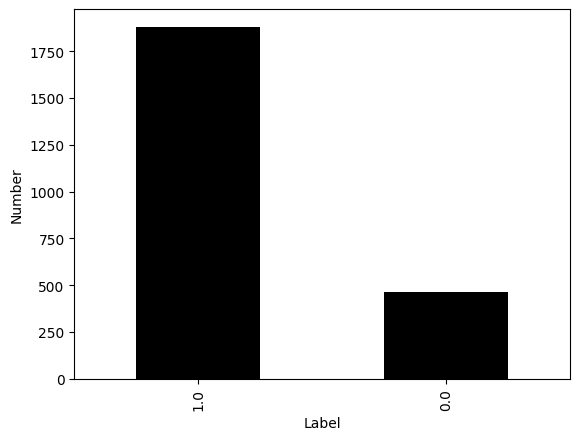

In [ ]:
LABEL_NUM_FILE = 'label_number.png'
df["Label"].value_counts().plot(kind = 'bar', color = 'k')
plt.xlabel("Label")
plt.ylabel("Number")
plt.savefig(LABEL_NUM_FILE) # 구글 드라이브 내 figure 폴더에 저장

In [ ]:
X_data = df['Review']
y_data = df['Label']

In [ ]:
len_review_series = df["Review"].apply(lambda x: len(str(x)) if isinstance(x, str) else 0)
max(len_review_series)

295

In [ ]:
TEST_SIZE = 0.2 # Train: Test = 8 :2 분리
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE,
                                                    stratify = y_data)

In [ ]:
MODEL_NAME = "klue/bert-base" # 한국어 자연어 처리 딥러닝 모델
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2, from_pt=True)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

In [ ]:
# 입력 데이터(문장) 길이 제한
MAX_SEQ_LEN = 128

In [ ]:
def convert_data(X_data, y_data):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트
    tokens, masks, segments, targets = [], [], [], []

    for X, y in tqdm(zip(X_data, y_data)):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)

        # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros

        # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        targets.append(y)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

In [ ]:
# train 데이터를 Bert의 Input 타입에 맞게 변환
train_x, train_y = convert_data(X_train, y_train)

1876it [00:00, 4581.66it/s]


In [ ]:
# test 데이터를 Bert의 Input 타입에 맞게 변환
test_x, test_y = convert_data(X_test, y_test)

470it [00:00, 4035.31it/s]


In [ ]:
# token, mask, segment 입력 정의
token_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_word_ids')
mask_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_masks')
segment_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_segment')
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

In [ ]:
bert_output = bert_outputs[0]

In [ ]:
DROPOUT_RATE = 0.5
NUM_CLASS = 2
dropout = tf.keras.layers.Dropout(DROPOUT_RATE)(bert_output)
# Multi-class classification 문제이므로 activation function은 softmax로 설정
sentiment_layer = tf.keras.layers.Dense(NUM_CLASS, activation='softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02))(dropout)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_layer)

In [ ]:
# 옵티마이저 Rectified Adam 하이퍼파리미터 조정
OPTIMIZER_NAME = 'RAdam'
LEARNING_RATE = 5e-5
TOTAL_STEPS = 10000
MIN_LR = 1e-5
WARMUP_PROPORTION = 0.1
EPSILON = 1e-8
CLIPNORM = 1.0
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE,
                                          total_steps = TOTAL_STEPS,
                                          warmup_proportion = WARMUP_PROPORTION,
                                          min_lr = MIN_LR,
                                          epsilon = EPSILON,
                                          clipnorm = CLIPNORM)

In [ ]:
# 감정분류 모델 컴파일
sentiment_model.compile(optimizer = optimizer,
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics = ['accuracy'])

In [ ]:
MIN_DELTA = 1e-3
PATIENCE = 5

early_stopping = EarlyStopping(
    monitor = "val_accuracy",
    min_delta = MIN_DELTA,
    patience = PATIENCE)

In [ ]:
# 최고 성능의 모델 파일을 저장할 이름과 경로 설정
BEST_MODEL_NAME = '/content/drive/MyDrive/playdataproject/model/best_model(0).h5'
model_checkpoint = ModelCheckpoint(
    filepath = BEST_MODEL_NAME,
    monitor = "val_loss",
    mode = "min",
    save_best_only = True, # 성능 향상 시에만 모델 저장
    verbose = 1
)

In [ ]:
callbacks = [early_stopping, model_checkpoint]

In [ ]:
EPOCHS = 100
BATCH_SZIE = 16

sentiment_model.fit(train_x, train_y,
                    epochs = EPOCHS,
                    shuffle = True,
                    batch_size = BATCH_SZIE,
                    validation_data = (test_x, test_y),
                    callbacks = callbacks
                    )

Epoch 1/100
118/118 [==============================] - ETA: 0s - loss: 0.6884 - accuracy: 0.6775
Epoch 1: val_loss improved from inf to 0.67294, saving model to /content/drive/MyDrive/playdataproject/model/best_model(0).h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


118/118 [==============================] - 108s 564ms/step - loss: 0.6884 - accuracy: 0.6775 - val_loss: 0.6729 - val_accuracy: 0.8021
Epoch 2/100
118/118 [==============================] - ETA: 0s - loss: 0.6453 - accuracy: 0.8017
Epoch 2: val_loss improved from 0.67294 to 0.60286, saving model to /content/drive/MyDrive/playdataproject/model/best_model(0).h5
118/118 [==============================] - 84s 717ms/step - loss: 0.6453 - accuracy: 0.8017 - val_loss: 0.6029 - val_accuracy: 0.8021
Epoch 3/100
118/118 [==============================] - ETA: 0s - loss: 0.5879 - accuracy: 0.8241
Epoch 3: val_loss improved from 0.60286 to 0.52544, saving model to /content/drive/MyDrive/playdataproject/model/best_model(0).h5
118/118 [==============================] - 80s 677ms/step - loss: 0.5879 - accuracy: 0.8241 - val_loss: 0.5254 - val_accuracy: 0.9106
Epoch 4/100
118/118 [==============================] - ETA: 0s - loss: 0.5165 - accuracy: 0.8838
Epoch 4: val_loss improved from 0.52544 to 0.4

In [ ]:
# 성능평가

In [ ]:
from transformers import TFBertForSequenceClassification
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope

# 모델을 로드할때 해당layer가 제대로 인식되도록 사용자 지정 객체 스코프에 등록 , 로드
with custom_object_scope({'TFBertForSequenceClassification': TFBertForSequenceClassification}):
    loaded_model = load_model('/content/drive/MyDrive/playdataproject/model/best_model(0).h5')

In [ ]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_masks (InputLayer)    [(None, 128)]                0         []                            
                                                                                                  
 input_segment (InputLayer)  [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_for_sequence_class  TFSequenceClassifierOutput   1106188   ['input_word_ids[0][0]',  

In [ ]:
def predict_sentence(input_sentence,input_label):
    # 입력을 BERT 모델에 맞게 변환
    input_data = convert_data([input_sentence],[input_label])

    input_tokens, input_masks, input_segments = input_data[0]
    test = [input_tokens , input_masks, input_segments]
    # 텐서로 변환
    # input_tokens = tf.constant(input_tokens)
    # input_masks = tf.constant(input_masks)
    # input_segments = tf.constant(input_segments)

    # 모델 예측
    predictions = loaded_model.predict(test)

    # 예측된 클래스 및 확률 출력
    predicted_class = np.argmax(predictions, axis=-1)[0]

    print(f"예측된 클래스: {predicted_class}")
    print(f"클래스별 확률: {predictions}")

In [ ]:
input_sentence = input("분류할 문장을 입력하세요: ")
input_label = input("부정데이터면 0  긍정데이터면 1을 입력하세요: ")
# 문장 예측
predict_sentence(input_sentence,input_label)

분류할 문장을 입력하세요: 위생은 별로에요
부정데이터면 0  긍정데이터면 1을 입력하세요: 0


1it [00:00, 720.67it/s]


1/1 [==============================] - 4s 4s/step
예측된 클래스: 0
클래스별 확률: [[0.7502811  0.24971893]]


In [ ]:
# # 최고 성능의 모델 불러오기
# sentiment_model_best = tf.keras.models.load_model(BEST_MODEL_NAME,
#                                                   custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})

In [ ]:
# 모델이 예측한 라벨 도출
predicted_value = loaded_model.predict(test_x)
predicted_label = np.argmax(predicted_value, axis = 1)

15/15 [==============================] - 7s 279ms/step


In [ ]:
print(f'긍정: {"%.2f%%" % (len(pos_result)/ len(data) * 100.0)}')
print(f'부정: {"%.2f%%" % (len(neg_result)/ len(data) * 100.0)}')
print(len(pos_result))

긍정: 77.08%
부정: 22.92%
390


In [ ]:
CL_REPORT_FILE = "/content/drive/MyDrive/project/cl_report(0).csv"

cl_report = classification_report(test_y, predicted_label, output_dict = True)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(3)
cl_report_df.to_csv(CL_REPORT_FILE)
print(cl_report_df)

              precision  recall  f1-score  support
0.0               0.739   0.882     0.804   93.000
1.0               0.969   0.923     0.946  377.000
accuracy          0.915   0.915     0.915    0.915
macro avg         0.854   0.902     0.875  470.000
weighted avg      0.924   0.915     0.918  470.000


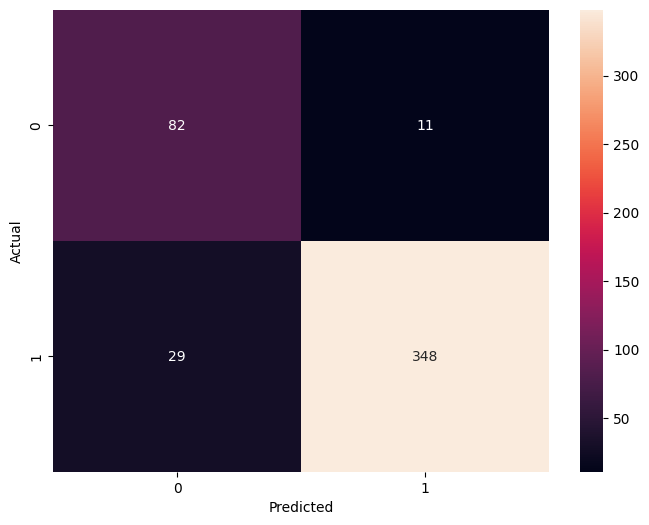

In [ ]:
FIGURE_FILE = "/content/drive/MyDrive/project/cf_matrix(0).png"

cf_matrix = confusion_matrix(test_y, predicted_label)
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(cf_matrix, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(FIGURE_FILE)
plt.show()